In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.express as px

In [31]:


# Step 1: Load cleaned transactional-level data
df = pd.read_csv("../data/cleaned_customer_data.csv", parse_dates=['sale_date', 'last_purchase_date'])

# Step 2: Aggregate to customer level
customer_df = df.groupby('customer_id').agg({
    'age': 'first',
    'tenure_months': 'max',
    'total_value': 'sum',
    'quantity': 'sum',
    'sale_id': 'count',
    'sale_date': 'max',
    'last_purchase_date': 'max',
    'product_id': pd.Series.nunique,
    'category': pd.Series.nunique
}).rename(columns={
    'sale_id': 'total_orders',
    'total_value': 'total_spend',
    'quantity': 'total_quantity',
    'product_id': 'product_diversity',
    'category': 'category_diversity'
}).reset_index()

customer_df


,customer_id,age,tenure_months,total_spend,total_quantity,total_orders,sale_date,last_purchase_date,product_diversity,category_diversity
0,CUST00001,43,50,24000,2,1,2023-05-19,2023-07-18,1,1
1,CUST00002,22,37,84300,11,4,2023-04-03,2023-06-27,4,3
2,CUST00003,59,18,130150,14,4,2023-05-03,2023-02-06,3,3
3,CUST00004,29,3,69000,8,3,2022-10-02,2023-11-28,3,2
4,CUST00005,53,45,8000,1,1,2021-10-11,2023-04-05,1,1
...,...,...,...,...,...,...,...,...,...,...
1910,CUST01995,48,31,300,3,1,2020-02-07,2023-10-05,1,1
1911,CUST01997,53,19,120500,17,5,2023-03-30,2023-12-31,4,3
1912,CUST01998,46,54,3000,1,1,2020-04-26,2023-07-10,1,1
1913,CUST01999,53,31,45300,9,3,2023-03-04,2023-04-04,3,2


In [32]:
# Step 3: Derived Features
customer_df['avg_order_value'] = customer_df['total_spend'] / customer_df['total_orders']
customer_df['purchase_frequency'] = customer_df['total_orders'] / customer_df['tenure_months']
customer_df['recency_days'] = (pd.to_datetime('2024-01-01') - customer_df['last_purchase_date']).dt.days

In [33]:
# Step 4: Feature selection for clustering
features = [
    'tenure_months', 'total_spend', 'total_quantity',
    'avg_order_value', 'purchase_frequency'
]
X = customer_df[features]


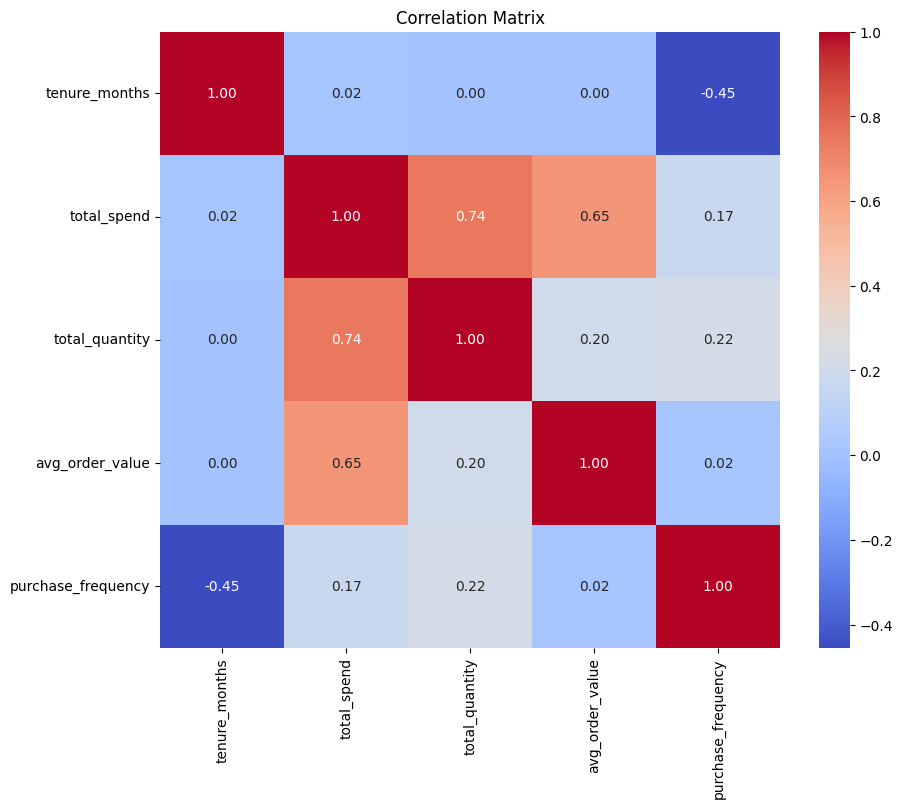

 Highly correlated features to drop: []


In [34]:
corr_matrix = X.corr()

# Step 3: Plot heatmap for visual inspection
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Step 4: Identify highly correlated features (threshold > 0.85)
# We'll only look at upper triangle of matrix to avoid duplicate pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 5: Find features with high correlation
correlated_features = [column for column in upper.columns if any(upper[column].abs() > 0.85)]
print(" Highly correlated features to drop:", correlated_features)

In [35]:
customer_df[customer_df['customer_id']=='CUST01195']

,customer_id,age,tenure_months,total_spend,total_quantity,total_orders,sale_date,last_purchase_date,product_diversity,category_diversity,avg_order_value,purchase_frequency,recency_days
1139,CUST01195,64,28,234500,20,7,2023-10-27,2023-08-18,5,3,33500.0,0.25,136


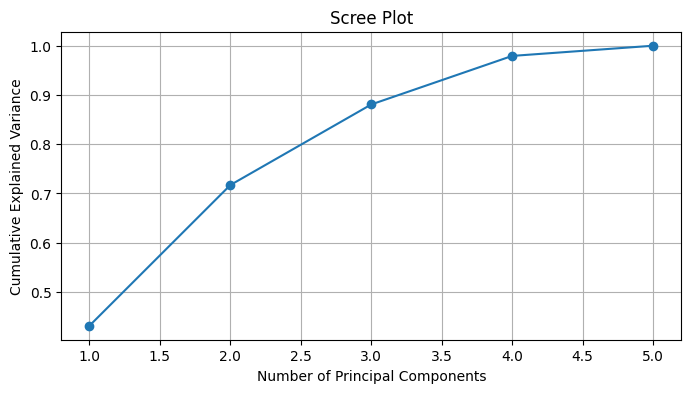

In [36]:
# Step 5: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: PCA - Scree Plot
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

/Users/shubhau/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 129461 (\N{LEG}) missing from current font.



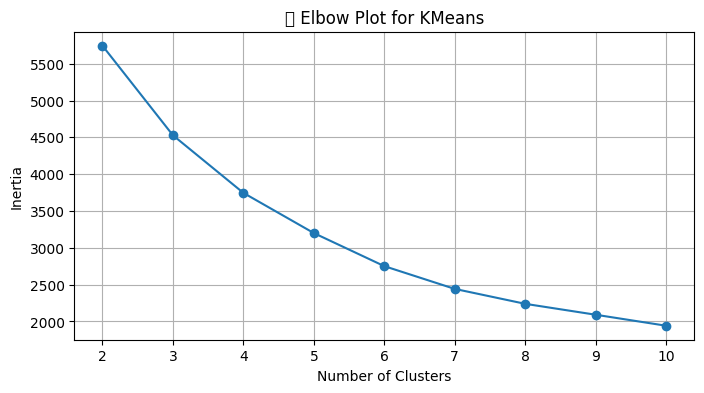

In [37]:
# Step 7: Elbow Plot - KMeans
X_pca_2d = PCA(n_components=3).fit_transform(X_scaled)
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_pca_2d)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("🦵 Elbow Plot for KMeans")
plt.grid(True)
plt.show()

In [38]:

# Step 8: Final KMeans (set k based on elbow)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_pca_2d)

# Step 9: Add results
customer_df['Cluster'] = clusters
customer_df['PCA1'] = X_pca_2d[:, 0]
customer_df['PCA2'] = X_pca_2d[:, 1]
customer_df['PCA3'] = X_pca_2d[:, 2]



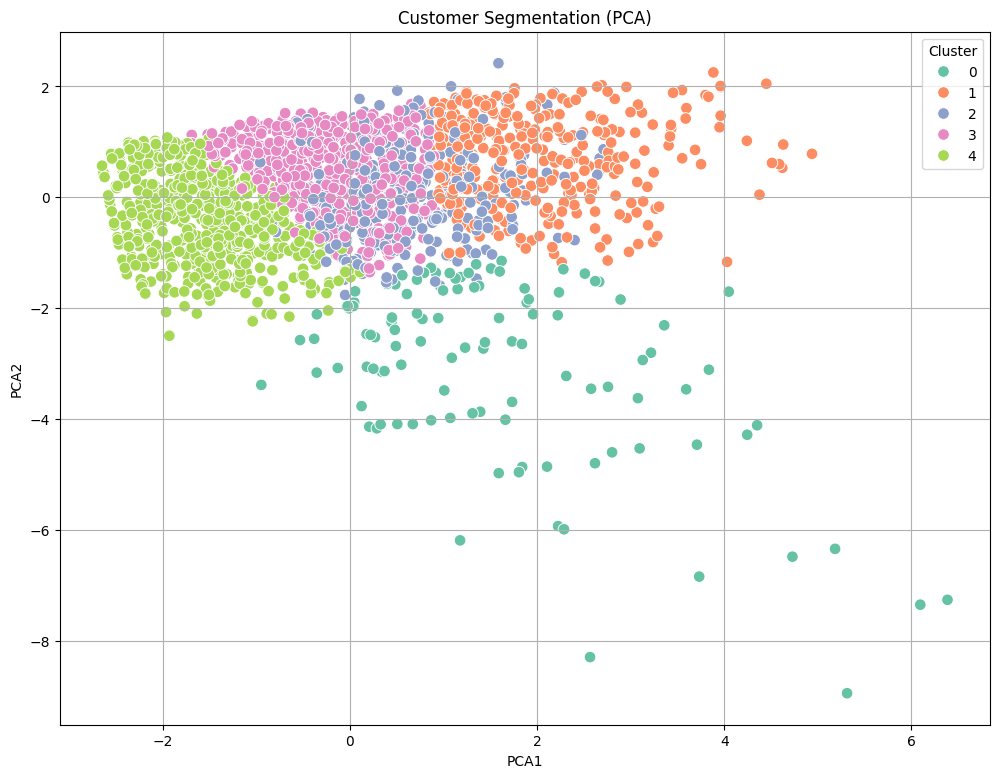

In [39]:
# Step 10: Cluster Visualization
plt.figure(figsize=(12, 9))
sns.scatterplot(data=customer_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=70)
plt.title("Customer Segmentation (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()



In [40]:

# Enhanced 3D PCA Scatter Plot
fig = px.scatter_3d(
    customer_df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color=customer_df['Cluster'].astype(str),
    title='3D PCA Cluster Visualization',
    labels={'Cluster': 'Cluster'},
    opacity=0.7,
    width=1000,          # Increase figure width
    height=1000           # Increase figure height
)

# Customize marker size and layout
fig.update_traces(marker=dict(size=6, line=dict(width=0.5, color=None)))

# Improve camera view and lighting
fig.update_layout(
    scene=dict(
        xaxis_title='PCA 1',
        yaxis_title='PCA 2',
        zaxis_title='PCA 3',
        xaxis=dict(backgroundcolor="rgb(230, 230,230)", gridcolor="white"),
        yaxis=dict(backgroundcolor="rgb(230, 230,230)", gridcolor="white"),
        zaxis=dict(backgroundcolor="rgb(230, 230,230)", gridcolor="white"),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend_title_text='Cluster',
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))  # Adjust camera angle
)

fig.show()

In [41]:
# Re-grouping by cluster and calculating mean values
cluster_summary = customer_df.groupby("Cluster")[features].mean().round(2)

# Apply formatting
formatted_summary = cluster_summary.copy()

# 💵 Format currency fields in thousands of dollars
formatted_summary["total_spend"] = cluster_summary["total_spend"].apply(lambda x: f"${x/1000:.1f}K")
formatted_summary["avg_order_value"] = cluster_summary["avg_order_value"].apply(lambda x: f"${x/1000:.2f}k")

# 📦 Format quantity-based fields
formatted_summary["total_quantity"] = cluster_summary["total_quantity"].apply(lambda x: f"{x:.0f} units")
formatted_summary["purchase_frequency"] = cluster_summary["purchase_frequency"].apply(lambda x: f"{x:.1f} orders/mo")

# ⏱️ Format time-related features
formatted_summary["tenure_months"] = cluster_summary["tenure_months"].apply(lambda x: f"{x:.0f} months")

formatted_summary = formatted_summary.reset_index()


cluster_map = {
    0: "At-Risk old Customers",
    1: "Rising new  Customers",
    2: "Reliable/Loyal Customers",
    3: "Premium New Customers",
    4: "Luxury Shoppers"
}
formatted_summary['Cluster_Label'] = formatted_summary['Cluster'].map(cluster_map)

display(formatted_summary)


,Cluster,tenure_months,total_spend,total_quantity,avg_order_value,purchase_frequency,Cluster_Label
0,0,3 months,$110.9K,14 units,$24.64k,2.3 orders/mo,At-Risk old Customers
1,1,35 months,$179.7K,17 units,$35.59k,0.2 orders/mo,Rising new Customers
2,2,22 months,$98.4K,8 units,$43.81k,0.2 orders/mo,Reliable/Loyal Customers
3,3,41 months,$73.7K,10 units,$22.27k,0.1 orders/mo,Premium New Customers
4,4,26 months,$21.5K,5 units,$10.22k,0.2 orders/mo,Luxury Shoppers


In [27]:
# Strategic Implications
# Segment-Specific Strategies

# Cluster 0 – "At-Risk Veterans"
# Might be at risk of churn
# Target with re-engagement campaigns, loyalty rewards

# Cluster 1 – "Rising Stars"
# New but showing promise
# Encourage loyalty with welcome offers, personalized deals

# Cluster 2 – "Reliable Loyalists"
# Strong lifetime value
# Retain with VIP programs, feedback collection

# Cluster 3 – "Premium Newcomers"
# High frequency early on
# Could indicate business buyers or bulk shoppers
# Need early retention and upselling

# Cluster 4 – "Luxury Shoppers"
# Small volume, huge value
# Could be executives or high-net-worth clients
# Offer exclusive services or concierge sales

In [28]:
with open('../models/segment_model.pkl','wb') as f:
    pickle.dump(kmeans,f)

In [29]:
customer_df.columns

Index(['customer_id', 'age', 'tenure_months', 'total_spend', 'total_quantity',
       'total_orders', 'sale_date', 'last_purchase_date', 'product_diversity',
       'category_diversity', 'avg_order_value', 'purchase_frequency',
       'recency_days', 'Cluster', 'PCA1', 'PCA2', 'PCA3'],
      dtype='object')